<a href="https://colab.research.google.com/github/AshwinAkash24/DL-LSTM/blob/main/DL_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step-1: Import Libraries

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [3]:
data = pd.read_csv("ner_dataset.csv", encoding="latin1").ffill()

In [4]:
words = list(data["Word"].unique())
tags = list(data["Tag"].unique())

In [5]:
if "ENDPAD" not in words:
    words.append("ENDPAD")

if "PAD" not in tags:
    tags.append("PAD")

if "O" not in tags:
    print("Warning: 'O' tag not present in dataset. Continuing without it.")

In [6]:
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {i: t for t, i in tag2idx.items()}

# Step-2: Get Unique Words And Tags

In [7]:
print("Unique words in corpus:", data['Word'].nunique())
print("Unique tags in corpus:", data['Tag'].nunique())
print("All tags (including PAD):", tags)

Unique words in corpus: 35177
Unique tags in corpus: 17
All tags (including PAD): ['O', 'B-geo', 'B-gpe', 'B-per', 'I-geo', 'B-org', 'I-org', 'B-tim', 'B-art', 'I-art', 'I-per', 'I-gpe', 'I-tim', 'B-nat', 'B-eve', 'I-eve', 'I-nat', 'PAD']


In [8]:
class SentenceGetter:
    def __init__(self, data):

        grouped = data.groupby("Sentence #", group_keys=False).apply(
            lambda s: [(w, t) for w, t in zip(s["Word"], s["Tag"])]
        )
        self.sentences = list(grouped)

In [9]:
getter = SentenceGetter(data)
sentences = getter.sentences
print("Example sentence (index 0):", sentences[0])

Example sentence (index 0): [('Thousands', 'O'), ('of', 'O'), ('demonstrators', 'O'), ('have', 'O'), ('marched', 'O'), ('through', 'O'), ('London', 'B-geo'), ('to', 'O'), ('protest', 'O'), ('the', 'O'), ('war', 'O'), ('in', 'O'), ('Iraq', 'B-geo'), ('and', 'O'), ('demand', 'O'), ('the', 'O'), ('withdrawal', 'O'), ('of', 'O'), ('British', 'B-gpe'), ('troops', 'O'), ('from', 'O'), ('that', 'O'), ('country', 'O'), ('.', 'O')]


In [10]:
X = [[word2idx[w] for w, t in s] for s in sentences]
y = [[tag2idx[t] for w, t in s] for s in sentences]

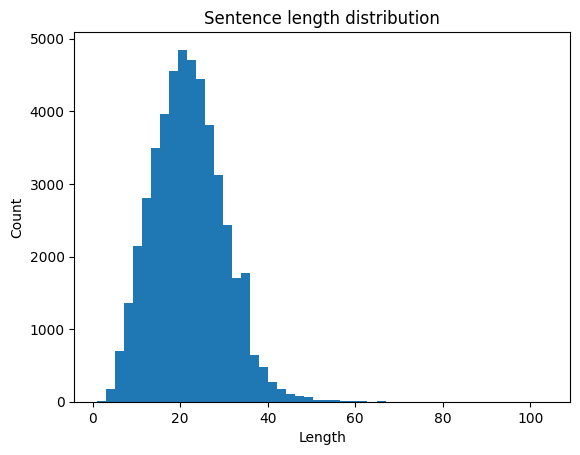

In [11]:
plt.hist([len(s) for s in sentences], bins=50)
plt.title("Sentence length distribution")
plt.xlabel("Length")
plt.ylabel("Count")
plt.show()

# Step-3: Separate X and Y

In [12]:
max_len = 50

X_tensors = [torch.tensor(seq, dtype=torch.long) for seq in X]
y_tensors = [torch.tensor(seq, dtype=torch.long) for seq in y]

In [13]:
pad_input_value = word2idx["ENDPAD"]
pad_label_value = tag2idx["PAD"]

In [14]:
X_pad = pad_sequence(X_tensors, batch_first=True, padding_value=pad_input_value)
y_pad = pad_sequence(y_tensors, batch_first=True, padding_value=pad_label_value)

In [15]:
if X_pad.size(1) < max_len:

    pad_amt = max_len - X_pad.size(1)
    X_pad = torch.cat([X_pad, torch.full((X_pad.size(0), pad_amt), pad_input_value, dtype=torch.long)], dim=1)
    y_pad = torch.cat([y_pad, torch.full((y_pad.size(0), pad_amt), pad_label_value, dtype=torch.long)], dim=1)
else:
    X_pad = X_pad[:, :max_len]
    y_pad = y_pad[:, :max_len]

In [16]:
print("X_pad shape:", X_pad.shape)
print("y_pad shape:", y_pad.shape)

X_pad shape: torch.Size([47959, 50])
y_pad shape: torch.Size([47959, 50])


In [17]:
dataset_size = X_pad.size(0)
perm = torch.randperm(dataset_size)
train_size = int(0.8 * dataset_size)
train_idx = perm[:train_size]
test_idx = perm[train_size:]

X_train = X_pad[train_idx]
y_train = y_pad[train_idx]
X_test = X_pad[test_idx]
y_test = y_pad[test_idx]

# Step-4: Now Get NERDataset

In [18]:
class NERDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return {
            "input_ids": self.X[idx],
            "labels": self.y[idx]
        }

In [19]:
train_loader = DataLoader(NERDataset(X_train, y_train), batch_size=32, shuffle=True)
test_loader = DataLoader(NERDataset(X_test, y_test), batch_size=32, shuffle=False)

In [20]:
class BiLSTMTagger(nn.Module):
    def __init__(self, vocab_size, tagset_size, embedding_dim=50, hidden_dim=100, dropout=0.1):
        super(BiLSTMTagger, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.dropout = nn.Dropout(dropout)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, tagset_size)

    def forward(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        x, _ = self.lstm(x)
        out = self.fc(x)
        return out

In [21]:
vocab_size = len(word2idx) + 1
tagset_size = len(tag2idx)

In [22]:
model = BiLSTMTagger(vocab_size=vocab_size, tagset_size=tagset_size).to(device)

In [23]:
loss_fn = nn.CrossEntropyLoss(ignore_index=pad_label_value)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Step-5: Train The Model

In [24]:
def train_model(model, train_loader, val_loader, loss_fn, optimizer, epochs=3):
    train_losses, val_losses = [], []
    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        for batch in train_loader:
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)  # shape (batch, seq_len)
            optimizer.zero_grad()
            outputs = model(input_ids)
            loss = loss_fn(outputs.view(-1, tagset_size), labels.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch["input_ids"].to(device)
                labels = batch["labels"].to(device)
                outputs = model(input_ids)
                loss = loss_fn(outputs.view(-1, tagset_size), labels.view(-1))
                val_loss += loss.item()

        train_losses.append(total_loss)
        val_losses.append(val_loss)
        print(f"Epoch {epoch+1}/{epochs} — Train Loss: {total_loss:.4f} — Val Loss: {val_loss:.4f}")

    return train_losses, val_losses

# Step-6: Evaluate The Model

In [25]:
def evaluate_model(model, test_loader):
    model.eval()
    true_tags, pred_tags = [], []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)
            outputs = model(input_ids)
            preds = torch.argmax(outputs, dim=-1)
            for i in range(labels.size(0)):
                for j in range(labels.size(1)):
                    lab = labels[i, j].item()
                    if lab != pad_label_value:
                        true_tags.append(idx2tag[lab])
                        pred_tags.append(idx2tag[preds[i, j].item()])
    return true_tags, pred_tags

In [26]:
train_losses, val_losses = train_model(model, train_loader, test_loader, loss_fn, optimizer, epochs=3)
true_tags, pred_tags = evaluate_model(model, test_loader)

Epoch 1/3 — Train Loss: 513.7850 — Val Loss: 70.7438
Epoch 2/3 — Train Loss: 236.2950 — Val Loss: 49.7733
Epoch 3/3 — Train Loss: 177.5879 — Val Loss: 42.8021


# STep-7: Get Classification Report

In [27]:
try:
    from sklearn.metrics import classification_report
    print("\nClassification Report (ignoring PAD):")
    print(classification_report(true_tags, pred_tags, zero_division=0))
except Exception as e:
    print("sklearn not available or other error while creating classification report:", e)


Classification Report (ignoring PAD):
              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00        83
       B-eve       0.86      0.30      0.44        61
       B-geo       0.79      0.89      0.83      7578
       B-gpe       0.94      0.90      0.92      3199
       B-nat       0.50      0.07      0.13        40
       B-org       0.76      0.57      0.65      3962
       B-per       0.77      0.73      0.75      3436
       B-tim       0.92      0.81      0.86      4169
       I-art       0.00      0.00      0.00        59
       I-eve       0.33      0.09      0.14        45
       I-geo       0.79      0.71      0.75      1577
       I-gpe       0.93      0.37      0.53        38
       I-nat       0.00      0.00      0.00         6
       I-org       0.76      0.68      0.72      3408
       I-per       0.80      0.86      0.83      3506
       I-tim       0.82      0.67      0.74      1342
           O       0.98      0.99      0.9

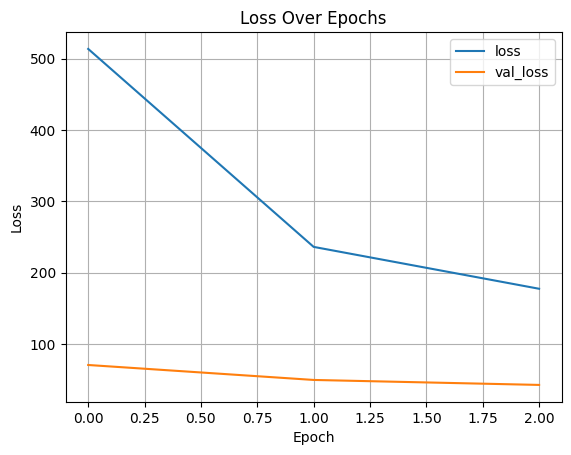

In [28]:
history_df = pd.DataFrame({"loss": train_losses, "val_loss": val_losses})
history_df.plot(title="Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [29]:
sample_idx = 0
if sample_idx < len(X_test):
    model.eval()
    sample = X_test[sample_idx].unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(sample)
        preds = torch.argmax(output, dim=-1).squeeze().cpu().numpy()
    true = y_test[sample_idx].numpy()
    print("{:<15} {:<12} {}".format("Word", "True", "Pred"))
    print("-" * 42)
    for w_id, true_tag_idx, pred_tag_idx in zip(X_test[sample_idx], true, preds):
        if w_id.item() != pad_input_value:
            word = words[w_id.item() - 1]
            true_label = idx2tag[int(true_tag_idx)]
            pred_label = idx2tag[int(pred_tag_idx)]
            print(f"{word: <15} {true_label: <12} {pred_label}")
else:
    print("sample_idx out of range for X_test")

Word            True         Pred
------------------------------------------
The             O            O
sole            O            O
dissenting      O            O
justice         O            O
,               O            O
Edmund          B-per        O
Levy            I-per        I-per
,               O            O
said            O            O
the             O            O
plan            O            O
should          O            O
be              O            O
canceled        O            O
.               O            O
